In [1]:
import cv2
import numpy as np
import glob


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML



%matplotlib inline

In [2]:
def calibrate_camera(objpoints, imgpoints, calibration_image):
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return (ret, mtx, dist, rvecs, tvecs)  

def undistort_image(image, mtx, dist):    
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_image

def getWarpMatrixes():
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    return M, M_inv

def warp_perspective(undistored_image, M):
    img_size = (undistored_image.shape[1], undistored_image.shape[0])

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undistored_image, M, img_size)

    # Return the resulting image and matrix
    return warped

def plot_two_images_side_by_side(image1, image2, title1, title2, cmap):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(image1, cmap))
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(cv2.cvtColor(image2, cmap))
    ax2.set_title(title2, fontsize=30)
    
def plot_images_side_by_side(images, titles, cmaps):
    f, axis = plt.subplots(1, len(images), figsize=(20,10))
    for idx, ax in enumerate(axis):
        if cmaps[idx] == 'gray':
            axis[idx].imshow(images[idx], cmap='gray')
        else:
            axis[idx].imshow(images[idx])
        ax.set_title(titles[idx])
    
M, M_inv = getWarpMatrixes()

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)

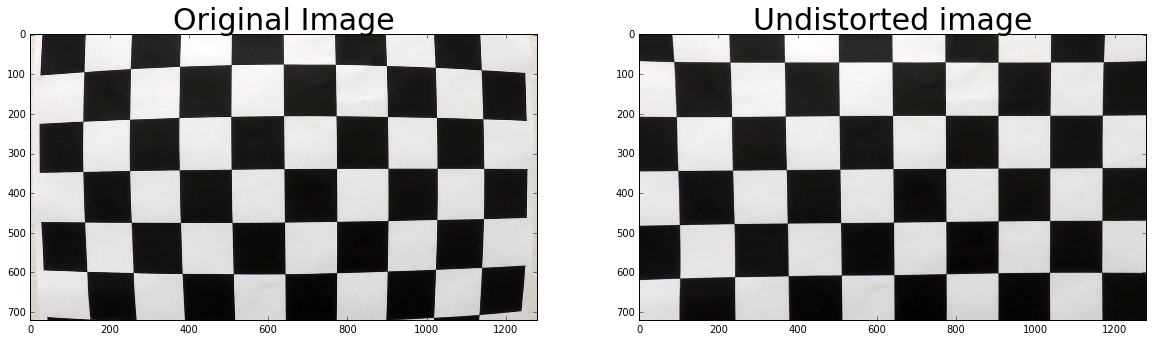

In [5]:
calib_image_name = 'camera_cal/calibration1.jpg'      
ret, mtx, dist, rvecs, tvecs = calibrate_camera(objpoints, imgpoints, calib_image_name)
img = cv2.imread(calib_image_name)
undistort_img = undistort_image(img, mtx, dist) 
plot_two_images_side_by_side(img, undistort_img, 'Original Image', 'Undistorted image', cv2.COLOR_BGR2RGB)

In [ ]:
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    undistorted_image = undistort_image(image, mtx, dist)
    plot_two_images_side_by_side(image, undistorted_image, 'Original Image', 'Undistorted image', cv2.COLOR_BGR2RGB)

In [ ]:
calib_image_name = 'test_images/straight_lines1.jpg'
image = cv2.imread(calib_image_name)
undistort_img = undistort_image(image, mtx, dist)
warped_image = warp_perspective(undistort_img, M)
plot_two_images_side_by_side(image, warped_image, 'Original Image', 'Warped image', cv2.COLOR_BGR2RGB)

In [ ]:
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    undistorted_image = undistort_image(image, mtx, dist)
    warped_image = warp_perspective(undistorted_image, M)
    plot_two_images_side_by_side(image, warped_image, 'Original Image', 'Warped image', cv2.COLOR_BGR2RGB)

In [9]:
def sobelx_threshold(img, thresh_min = 20, thresh_max = 100):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def sobely_threshold(img, thresh_min = 20, thresh_max = 100):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)

    # Sobel y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Threshold x gradient
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sybinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def b_threshold(img, thresh_min = 128, thresh_max = 255):

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    b_channel = lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= thresh_min) & (b_channel <= thresh_max)]  = 1
    
    return b_binary

def yc_threshold(img, thresh_min = 128, thresh_max = 255):
    ycbcr = lab = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    
    yc_channel = ycbcr[:,:,0]
    yc_binary = np.zeros_like(yc_channel)
    yc_binary[(yc_channel >= thresh_min) & (yc_channel <= thresh_max)]  = 1
    return yc_binary

def apply_all_thresholds(image):
    img = np.copy(image)

    sx_binary = sobelx_threshold(img, 20, 100)
    sy_binary = sobely_threshold(img, 20, 100)
    #sy_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(40, 100))
    b_binary = b_threshold(img, 150, 255)
    yc_binary = yc_threshold(img, 210, 255)
  
    
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (sy_binary == 1) | (b_binary == 1) | (yc_binary == 1)] = 1
    
    return combined_binary, sx_binary, sy_binary, b_binary, yc_binary

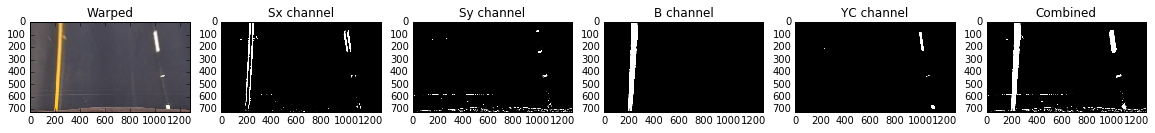

In [18]:
calib_image_name = 'test_images/straight_lines1.jpg'
image = cv2.imread(calib_image_name)
undistort_img = undistort_image(image, mtx, dist)
warped_image = warp_perspective(undistort_img, M)

combined_binary, sx_binary, sy_binary, b_binary, yc_binary = apply_all_thresholds(warped_image)
#combined_binary = (combined_binary.copy() * 255).astype('uint8')

images=[cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB), sx_binary, sy_binary, b_binary, yc_binary, combined_binary]
titles = ['Warped', 'Sx channel', 'Sy channel', 'B channel', 'YC channel', 'Combined']
cmaps = [cv2.COLOR_BGR2RGB, 'gray', 'gray', 'gray', 'gray', 'gray']
plot_images_side_by_side(images, titles, cmaps)


    

In [ ]:
images = glob.glob('test_images/*.jpg')
images_plot = []
titles = ['Warped', 'Sx channel', 'Sy channel', 'B channel', 'Yc Channel', 'Combined']
cmaps = [cv2.COLOR_BGR2RGB, 'gray', 'gray', 'gray', 'gray', 'gray']
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    undistorted_image = undistort_image(image, mtx, dist)
    warped_image = warp_perspective(undistorted_image, M) 
    combined_binary, sx_binary, sy_binary, b_binary, yc_binary = apply_all_thresholds(warped_image)  
    images_plot=[cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB), sx_binary, sy_binary, b_binary, yc_binary, combined_binary]
    plot_images_side_by_side(images_plot, titles, cmaps)

In [ ]:
print(combined_binary.shape)

In [20]:
def find_line(image):
    undistort_img = undistort_image(image, mtx, dist)
    warped_image = warp_perspective(undistort_img, M)

    combined_binary, sx_binary, sy_binary, b_binary, yc_binary = apply_all_thresholds(warped_image)
    binary_warped = np.copy(combined_binary)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    right_bottom_x = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    left_bottom_x = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    center = 640 - ((right_bottom_x+left_bottom_x)/2)   
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(righty)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(righty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.polylines(warped_image, np.int_([pts]), isClosed=False, color=(255,0,0), thickness = 40)
    cv2.fillPoly(warped_image, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warped_image, M_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result2 = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    a = [left_fit,left_fit]
    print(a)
    print(np.array(np.mean(a, axis =0)))
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))
    ax1.imshow(result)
    ax1.plot(left_fitx, ploty, color='cyan', linewidth=3)
    ax1.plot(right_fitx, ploty, color='cyan', linewidth=3)
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(720, 0)
    ax2.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    ax2.text(200, 100, 'Vehicle is {:.2f}m of center'.format(center*3.7/700), fontweight='bold' , color='white', fontsize=10)
    ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)), fontweight='bold' , color='white', fontsize=10)

[array([  1.48722138e-04,  -1.60024285e-01,   2.92208909e+02]), array([  1.48722138e-04,  -1.60024285e-01,   2.92208909e+02])]
[  1.48722138e-04  -1.60024285e-01   2.92208909e+02]


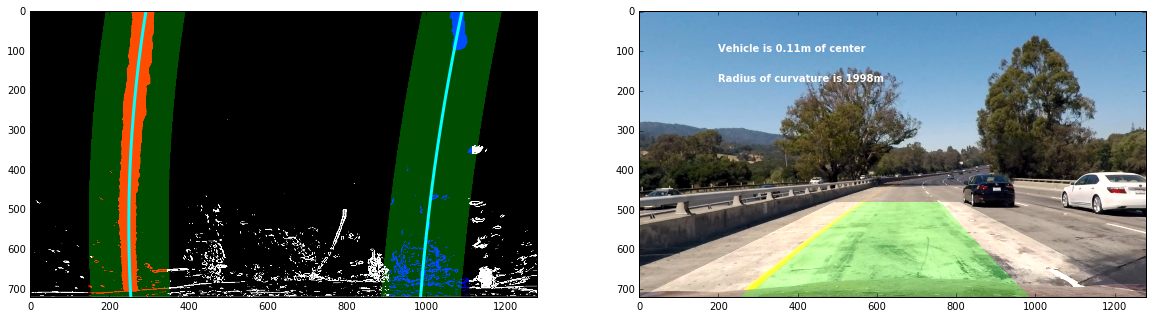

In [21]:
calib_image_name = 'test_images/test1.jpg'
image = cv2.imread(calib_image_name)
find_line(image)
#plot_line_points_on_image(binary_warped, left_lane_inds, right_lane_inds)

In [ ]:
images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    find_line(image)

In [70]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.n = 5
        
    def fast_search(self, xbase, binary_warped):
        print("fast")
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (self.current_fit[0]*(nonzeroy**2) + self.current_fit[1]*nonzeroy + self.current_fit[2] - margin)) & (nonzerox < (self.current_fit[0]*(nonzeroy**2) + self.current_fit[1]*nonzeroy + self.current_fit[2] + margin))) 
       
    
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 

        
        if not(len(leftx) > 0 and len(lefty) > 0):
            self.detected = false
        
        return leftx, lefty
            

    
    def blind_search(self, xbase, binary_warped):
        print("blind")
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = xbase
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 

        self.detected = True
        return leftx, lefty
        

        
        #left_fit_np = np.array(left_fit_g)

        ##if len(left_fit_g) > n:
        #    left_fit = np.mean(left_fit_np[-n:, :], axis=0)

        
        


In [87]:
# Processing pipeline for videos
def process_video(image_clip):
    image_clip = cv2.cvtColor(image_clip, cv2.COLOR_RGB2BGR)
    undistorted_img = undistort_image(image_clip, mtx, dist)
    warped_image = warp_perspective(undistorted_img, M)
    combined_binary, sx_binary, sy_binary, b_binary, yc_binary = apply_all_thresholds(warped_image)
    binary_warped = np.copy(combined_binary)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if Right.detected == True: # Perform blind search for right lane lines
        
        rightx, righty = Right.fast_search(rightx_base, binary_warped)
    else:
        rightx, righty = Right.blind_search(rightx_base, binary_warped)

    if Left.detected == True:# Perform blind search for left lane lines
        
        leftx, lefty = Left.fast_search(leftx_base, binary_warped)
    else:
        leftx, lefty = Left.blind_search(leftx_base, binary_warped)

    # Generate x and y values for plotting
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    Left.current_fit = left_fit
    Right.current_fit = right_fit
    
    Left.recent_xfitted.append(left_fit)
    if len(Left.recent_xfitted) > 5:
        Left.recent_xfitted.pop(0)
        #print(Left.recent_xfitted)
        left_fit = np.array(np.mean(Left.recent_xfitted, axis =0))
        
    Right.recent_xfitted.append(right_fit)
    if len(Right.recent_xfitted) > 5:
        Right.recent_xfitted.pop(0)
        right_fit = np.array(np.mean(Right.recent_xfitted, axis =0))
    
    
    
    
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.polylines(warped_image, np.int_([pts]), isClosed=False, color=(255,0,0), thickness = 40)
    cv2.fillPoly(warped_image, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warped_image, M_inv, (image_clip.shape[1], image_clip.shape[0])) 
    # Combine the result with the original image
    result2 = cv2.addWeighted(image_clip, 1, newwarp, 0.3, 0)
    

    
    final = cv2.cvtColor(result2, cv2.COLOR_RGB2BGR)
    return final
    

In [90]:
Left = Line()
Right = Line()
video_outputx = './result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_outputx, audio=False)



blind
blind
[MoviePy] >>>> Building video ./result.mp4
[MoviePy] Writing video ./result.mp4





  0%|          | 0/251 [00:00<?, ?it/s]


  0%|          | 1/251 [00:00<00:31,  8.05it/s]

fast
fast





  1%|          | 2/251 [00:00<00:32,  7.61it/s]

fast
fast





  1%|          | 3/251 [00:00<00:32,  7.72it/s]

fast
fast





  2%|▏         | 4/251 [00:00<00:31,  7.75it/s]

fast
fast





  2%|▏         | 5/251 [00:00<00:31,  7.76it/s]

fast
fast





  2%|▏         | 6/251 [00:00<00:31,  7.81it/s]

fast
fast





  3%|▎         | 7/251 [00:00<00:31,  7.80it/s]

fast
fast





  3%|▎         | 8/251 [00:01<00:31,  7.80it/s]

fast
fast





  4%|▎         | 9/251 [00:01<00:30,  7.88it/s]

fast
fast





  4%|▍         | 10/251 [00:01<00:30,  7.94it/s]

fast
fast





  4%|▍         | 11/251 [00:01<00:29,  8.00it/s]

fast
fast





  5%|▍         | 12/251 [00:01<00:30,  7.91it/s]

fast
fast





  5%|▌         | 13/251 [00:01<00:30,  7.91it/s]

fast
fast





  6%|▌         | 14/251 [00:01<00:29,  7.90it/s]

fast
fast





  6%|▌         | 15/251 [00:01<00:30,  7.84it/s]

fast
fast





  6%|▋         | 16/251 [00:02<00:29,  7.86it/s]

fast
fast





  7%|▋         | 17/251 [00:02<00:29,  7.90it/s]

fast
fast





  7%|▋         | 18/251 [00:02<00:29,  7.88it/s]

fast
fast





  8%|▊         | 19/251 [00:02<00:29,  7.93it/s]

fast
fast





  8%|▊         | 20/251 [00:02<00:29,  7.92it/s]

fast
fast





  8%|▊         | 21/251 [00:02<00:29,  7.90it/s]

fast
fast





  9%|▉         | 22/251 [00:02<00:28,  7.92it/s]

fast
fast





  9%|▉         | 23/251 [00:02<00:28,  7.93it/s]

fast
fast





 10%|▉         | 24/251 [00:03<00:28,  7.94it/s]

fast
fast





 10%|▉         | 25/251 [00:03<00:28,  7.96it/s]

fast
fast





 10%|█         | 26/251 [00:03<00:28,  8.00it/s]

fast
fast





 11%|█         | 27/251 [00:03<00:28,  7.98it/s]

fast
fast





 11%|█         | 28/251 [00:03<00:28,  7.95it/s]

fast
fast





 12%|█▏        | 29/251 [00:03<00:27,  7.95it/s]

fast
fast





 12%|█▏        | 30/251 [00:03<00:27,  7.91it/s]

fast
fast





 12%|█▏        | 31/251 [00:03<00:27,  7.91it/s]

fast
fast





 13%|█▎        | 32/251 [00:04<00:27,  7.95it/s]

fast
fast





 13%|█▎        | 33/251 [00:04<00:27,  7.98it/s]

fast
fast





 14%|█▎        | 34/251 [00:04<00:27,  8.00it/s]

fast
fast





 14%|█▍        | 35/251 [00:04<00:27,  8.00it/s]

fast
fast





 14%|█▍        | 36/251 [00:04<00:26,  7.97it/s]

fast
fast





 15%|█▍        | 37/251 [00:04<00:27,  7.91it/s]

fast
fast





 15%|█▌        | 38/251 [00:04<00:26,  7.92it/s]

fast
fast





 16%|█▌        | 39/251 [00:04<00:26,  7.89it/s]

fast
fast





 16%|█▌        | 40/251 [00:05<00:26,  7.88it/s]

fast
fast





 16%|█▋        | 41/251 [00:05<00:26,  7.96it/s]

fast
fast





 17%|█▋        | 42/251 [00:05<00:26,  7.95it/s]

fast
fast





 17%|█▋        | 43/251 [00:05<00:28,  7.36it/s]

fast
fast





 18%|█▊        | 44/251 [00:05<00:29,  7.07it/s]

fast
fast





 18%|█▊        | 45/251 [00:05<00:28,  7.18it/s]

fast
fast





 18%|█▊        | 46/251 [00:05<00:27,  7.34it/s]

fast
fast





 19%|█▊        | 47/251 [00:06<00:27,  7.36it/s]

fast
fast





 19%|█▉        | 48/251 [00:06<00:27,  7.44it/s]

fast
fast





 20%|█▉        | 49/251 [00:06<00:27,  7.41it/s]

fast
fast





 20%|█▉        | 50/251 [00:06<00:28,  7.08it/s]

fast
fast





 20%|██        | 51/251 [00:06<00:28,  7.13it/s]

fast
fast





 21%|██        | 52/251 [00:06<00:27,  7.22it/s]

fast
fast





 21%|██        | 53/251 [00:06<00:27,  7.26it/s]

fast
fast





 22%|██▏       | 54/251 [00:06<00:26,  7.37it/s]

fast
fast





 22%|██▏       | 55/251 [00:07<00:26,  7.36it/s]

fast
fast





 22%|██▏       | 56/251 [00:07<00:26,  7.22it/s]

fast
fast





 23%|██▎       | 57/251 [00:07<00:27,  7.08it/s]

fast
fast





 23%|██▎       | 58/251 [00:07<00:27,  7.00it/s]

fast
fast





 24%|██▎       | 59/251 [00:07<00:26,  7.12it/s]

fast
fast





 24%|██▍       | 60/251 [00:07<00:27,  7.04it/s]

fast
fast





 24%|██▍       | 61/251 [00:07<00:26,  7.19it/s]

fast
fast





 25%|██▍       | 62/251 [00:08<00:26,  7.06it/s]

fast
fast





 25%|██▌       | 63/251 [00:08<00:26,  7.07it/s]

fast
fast





 25%|██▌       | 64/251 [00:08<00:25,  7.22it/s]

fast
fast





 26%|██▌       | 65/251 [00:08<00:26,  7.15it/s]

fast
fast





 26%|██▋       | 66/251 [00:08<00:25,  7.23it/s]

fast
fast





 27%|██▋       | 67/251 [00:08<00:25,  7.25it/s]

fast
fast





 27%|██▋       | 68/251 [00:08<00:25,  7.13it/s]

fast
fast





 27%|██▋       | 69/251 [00:09<00:25,  7.02it/s]

fast
fast





 28%|██▊       | 70/251 [00:09<00:25,  7.20it/s]

fast
fast





 28%|██▊       | 71/251 [00:09<00:25,  7.05it/s]

fast
fast





 29%|██▊       | 72/251 [00:09<00:25,  7.07it/s]

fast
fast





 29%|██▉       | 73/251 [00:09<00:25,  6.95it/s]

fast
fast





 29%|██▉       | 74/251 [00:09<00:25,  7.03it/s]

fast
fast





 30%|██▉       | 75/251 [00:09<00:25,  6.78it/s]

fast
fast





 30%|███       | 76/251 [00:10<00:25,  6.97it/s]

fast
fast





 31%|███       | 77/251 [00:10<00:25,  6.89it/s]

fast
fast





 31%|███       | 78/251 [00:10<00:24,  7.04it/s]

fast
fast





 31%|███▏      | 79/251 [00:10<00:24,  6.99it/s]

fast
fast





 32%|███▏      | 80/251 [00:10<00:23,  7.19it/s]

fast
fast





 32%|███▏      | 81/251 [00:10<00:23,  7.20it/s]

fast
fast





 33%|███▎      | 82/251 [00:10<00:23,  7.29it/s]

fast
fast





 33%|███▎      | 83/251 [00:11<00:23,  7.14it/s]

fast
fast





 33%|███▎      | 84/251 [00:11<00:22,  7.31it/s]

fast
fast





 34%|███▍      | 85/251 [00:11<00:22,  7.26it/s]

fast
fast





 34%|███▍      | 86/251 [00:11<00:23,  7.09it/s]

fast
fast





 35%|███▍      | 87/251 [00:11<00:22,  7.28it/s]

fast
fast





 35%|███▌      | 88/251 [00:11<00:23,  7.01it/s]

fast
fast





 35%|███▌      | 89/251 [00:11<00:22,  7.11it/s]

fast
fast





 36%|███▌      | 90/251 [00:12<00:22,  7.15it/s]

fast
fast





 36%|███▋      | 91/251 [00:12<00:22,  7.18it/s]

fast
fast





 37%|███▋      | 92/251 [00:12<00:22,  7.08it/s]

fast
fast





 37%|███▋      | 93/251 [00:12<00:22,  7.09it/s]

fast
fast





 37%|███▋      | 94/251 [00:12<00:22,  7.10it/s]

fast
fast





 38%|███▊      | 95/251 [00:12<00:21,  7.23it/s]

fast
fast





 38%|███▊      | 96/251 [00:12<00:21,  7.08it/s]

fast
fast





 39%|███▊      | 97/251 [00:13<00:22,  6.99it/s]

fast
fast





 39%|███▉      | 98/251 [00:13<00:22,  6.82it/s]

fast
fast





 39%|███▉      | 99/251 [00:13<00:21,  7.08it/s]

fast
fast





 40%|███▉      | 100/251 [00:13<00:20,  7.19it/s]

fast
fast





 40%|████      | 101/251 [00:13<00:21,  7.11it/s]

fast
fast





 41%|████      | 102/251 [00:13<00:21,  6.94it/s]

fast
fast





 41%|████      | 103/251 [00:13<00:21,  6.91it/s]

fast
fast





 41%|████▏     | 104/251 [00:14<00:20,  7.08it/s]

fast
fast





 42%|████▏     | 105/251 [00:14<00:20,  7.12it/s]

fast
fast





 42%|████▏     | 106/251 [00:14<00:19,  7.27it/s]

fast
fast





 43%|████▎     | 107/251 [00:14<00:20,  7.12it/s]

fast
fast





 43%|████▎     | 108/251 [00:14<00:20,  6.94it/s]

fast
fast





 43%|████▎     | 109/251 [00:14<00:20,  6.91it/s]

fast
fast





 44%|████▍     | 110/251 [00:14<00:20,  6.90it/s]

fast
fast





 44%|████▍     | 111/251 [00:15<00:21,  6.63it/s]

fast
fast





 45%|████▍     | 112/251 [00:15<00:20,  6.70it/s]

fast
fast





 45%|████▌     | 113/251 [00:15<00:20,  6.67it/s]

fast
fast





 45%|████▌     | 114/251 [00:15<00:19,  6.90it/s]

fast
fast





 46%|████▌     | 115/251 [00:15<00:20,  6.72it/s]

fast
fast





 46%|████▌     | 116/251 [00:15<00:19,  6.78it/s]

fast
fast





 47%|████▋     | 117/251 [00:15<00:20,  6.67it/s]

fast
fast





 47%|████▋     | 118/251 [00:16<00:19,  6.94it/s]

fast
fast





 47%|████▋     | 119/251 [00:16<00:18,  7.12it/s]

fast
fast





 48%|████▊     | 120/251 [00:16<00:18,  6.97it/s]

fast
fast





 48%|████▊     | 121/251 [00:16<00:18,  7.04it/s]

fast
fast





 49%|████▊     | 122/251 [00:16<00:18,  6.87it/s]

fast
fast





 49%|████▉     | 123/251 [00:16<00:18,  6.96it/s]

fast
fast





 49%|████▉     | 124/251 [00:16<00:17,  7.18it/s]

fast
fast





 50%|████▉     | 125/251 [00:17<00:17,  7.22it/s]

fast
fast





 50%|█████     | 126/251 [00:17<00:17,  7.31it/s]

fast
fast





 51%|█████     | 127/251 [00:17<00:16,  7.40it/s]

fast
fast





 51%|█████     | 128/251 [00:17<00:17,  7.17it/s]

fast
fast





 51%|█████▏    | 129/251 [00:17<00:17,  6.82it/s]

fast
fast





 52%|█████▏    | 130/251 [00:17<00:17,  7.01it/s]

fast
fast





 52%|█████▏    | 131/251 [00:17<00:17,  6.96it/s]

fast
fast





 53%|█████▎    | 132/251 [00:18<00:16,  7.11it/s]

fast
fast





 53%|█████▎    | 133/251 [00:18<00:16,  7.07it/s]

fast
fast





 53%|█████▎    | 134/251 [00:18<00:16,  7.15it/s]

fast
fast





 54%|█████▍    | 135/251 [00:18<00:15,  7.25it/s]

fast
fast





 54%|█████▍    | 136/251 [00:18<00:16,  7.17it/s]

fast
fast





 55%|█████▍    | 137/251 [00:18<00:16,  6.93it/s]

fast
fast





 55%|█████▍    | 138/251 [00:18<00:16,  6.95it/s]

fast
fast





 55%|█████▌    | 139/251 [00:19<00:16,  6.99it/s]

fast
fast





 56%|█████▌    | 140/251 [00:19<00:16,  6.88it/s]

fast
fast





 56%|█████▌    | 141/251 [00:19<00:15,  7.00it/s]

fast
fast





 57%|█████▋    | 142/251 [00:19<00:15,  6.86it/s]

fast
fast





 57%|█████▋    | 143/251 [00:19<00:15,  6.97it/s]

fast
fast





 57%|█████▋    | 144/251 [00:19<00:15,  6.97it/s]

fast
fast





 58%|█████▊    | 145/251 [00:19<00:14,  7.14it/s]

fast
fast





 58%|█████▊    | 146/251 [00:20<00:15,  6.98it/s]

fast
fast





 59%|█████▊    | 147/251 [00:20<00:15,  6.80it/s]

fast
fast





 59%|█████▉    | 148/251 [00:20<00:14,  6.95it/s]

fast
fast





 59%|█████▉    | 149/251 [00:20<00:14,  6.94it/s]

fast
fast





 60%|█████▉    | 150/251 [00:20<00:14,  6.90it/s]

fast
fast





 60%|██████    | 151/251 [00:20<00:14,  7.03it/s]

fast
fast





 61%|██████    | 152/251 [00:20<00:14,  7.06it/s]

fast
fast





 61%|██████    | 153/251 [00:21<00:13,  7.12it/s]

fast
fast





 61%|██████▏   | 154/251 [00:21<00:13,  7.07it/s]

fast
fast





 62%|██████▏   | 155/251 [00:21<00:13,  7.10it/s]

fast
fast





 62%|██████▏   | 156/251 [00:21<00:13,  7.14it/s]

fast
fast





 63%|██████▎   | 157/251 [00:21<00:13,  7.16it/s]

fast
fast





 63%|██████▎   | 158/251 [00:21<00:12,  7.26it/s]

fast
fast





 63%|██████▎   | 159/251 [00:21<00:12,  7.38it/s]

fast
fast





 64%|██████▎   | 160/251 [00:22<00:12,  7.47it/s]

fast
fast





 64%|██████▍   | 161/251 [00:22<00:12,  7.47it/s]

fast
fast





 65%|██████▍   | 162/251 [00:22<00:12,  7.27it/s]

fast
fast





 65%|██████▍   | 163/251 [00:22<00:12,  7.23it/s]

fast
fast





 65%|██████▌   | 164/251 [00:22<00:12,  7.08it/s]

fast
fast





 66%|██████▌   | 165/251 [00:22<00:12,  6.97it/s]

fast
fast





 66%|██████▌   | 166/251 [00:22<00:12,  7.06it/s]

fast
fast





 67%|██████▋   | 167/251 [00:23<00:12,  6.83it/s]

fast
fast





 67%|██████▋   | 168/251 [00:23<00:12,  6.76it/s]

fast
fast





 67%|██████▋   | 169/251 [00:23<00:12,  6.66it/s]

fast
fast





 68%|██████▊   | 170/251 [00:23<00:12,  6.75it/s]

fast
fast





 68%|██████▊   | 171/251 [00:23<00:11,  6.97it/s]

fast
fast





 69%|██████▊   | 172/251 [00:23<00:11,  6.94it/s]

fast
fast





 69%|██████▉   | 173/251 [00:23<00:11,  7.06it/s]

fast
fast





 69%|██████▉   | 174/251 [00:24<00:11,  6.98it/s]

fast
fast





 70%|██████▉   | 175/251 [00:24<00:10,  7.04it/s]

fast
fast





 70%|███████   | 176/251 [00:24<00:10,  6.95it/s]

fast
fast





 71%|███████   | 177/251 [00:24<00:10,  7.00it/s]

fast
fast





 71%|███████   | 178/251 [00:24<00:10,  7.17it/s]

fast
fast





 71%|███████▏  | 179/251 [00:24<00:10,  7.00it/s]

fast
fast





 72%|███████▏  | 180/251 [00:24<00:10,  7.03it/s]

fast
fast





 72%|███████▏  | 181/251 [00:25<00:10,  6.98it/s]

fast
fast





 73%|███████▎  | 182/251 [00:25<00:09,  7.21it/s]

fast
fast





 73%|███████▎  | 183/251 [00:25<00:09,  7.30it/s]

fast
fast





 73%|███████▎  | 184/251 [00:25<00:09,  7.07it/s]

fast
fast





 74%|███████▎  | 185/251 [00:25<00:09,  7.22it/s]

fast
fast





 74%|███████▍  | 186/251 [00:25<00:09,  7.17it/s]

fast
fast





 75%|███████▍  | 187/251 [00:25<00:09,  7.06it/s]

fast
fast





 75%|███████▍  | 188/251 [00:26<00:09,  6.87it/s]

fast
fast





 75%|███████▌  | 189/251 [00:26<00:09,  6.75it/s]

fast
fast





 76%|███████▌  | 190/251 [00:26<00:08,  6.96it/s]

fast
fast





 76%|███████▌  | 191/251 [00:26<00:08,  7.05it/s]

fast
fast





 76%|███████▋  | 192/251 [00:26<00:08,  7.16it/s]

fast
fast





 77%|███████▋  | 193/251 [00:26<00:08,  7.10it/s]

fast
fast





 77%|███████▋  | 194/251 [00:26<00:07,  7.19it/s]

fast
fast





 78%|███████▊  | 195/251 [00:27<00:07,  7.04it/s]

fast
fast





 78%|███████▊  | 196/251 [00:27<00:07,  6.94it/s]

fast
fast





 78%|███████▊  | 197/251 [00:27<00:07,  6.93it/s]

fast
fast





 79%|███████▉  | 198/251 [00:27<00:07,  6.97it/s]

fast
fast





 79%|███████▉  | 199/251 [00:27<00:07,  6.94it/s]

fast
fast





 80%|███████▉  | 200/251 [00:27<00:07,  6.73it/s]

fast
fast





 80%|████████  | 201/251 [00:27<00:07,  6.92it/s]

fast
fast





 80%|████████  | 202/251 [00:28<00:06,  7.05it/s]

fast
fast





 81%|████████  | 203/251 [00:28<00:06,  7.27it/s]

fast
fast





 81%|████████▏ | 204/251 [00:28<00:06,  7.33it/s]

fast
fast





 82%|████████▏ | 205/251 [00:28<00:06,  7.09it/s]

fast
fast





 82%|████████▏ | 206/251 [00:28<00:06,  7.23it/s]

fast
fast





 82%|████████▏ | 207/251 [00:28<00:06,  7.32it/s]

fast
fast





 83%|████████▎ | 208/251 [00:28<00:05,  7.44it/s]

fast
fast





 83%|████████▎ | 209/251 [00:28<00:05,  7.16it/s]

fast
fast





 84%|████████▎ | 210/251 [00:29<00:05,  7.25it/s]

fast
fast





 84%|████████▍ | 211/251 [00:29<00:05,  6.96it/s]

fast
fast





 84%|████████▍ | 212/251 [00:29<00:05,  7.09it/s]

fast
fast





 85%|████████▍ | 213/251 [00:29<00:05,  7.17it/s]

fast
fast


fast
fast





 85%|████████▌ | 214/251 [00:29<00:05,  6.76it/s]


 86%|████████▌ | 215/251 [00:29<00:05,  6.96it/s]

fast
fast





 86%|████████▌ | 216/251 [00:29<00:05,  6.85it/s]

fast
fast





 86%|████████▋ | 217/251 [00:30<00:04,  6.88it/s]

fast
fast





 87%|████████▋ | 218/251 [00:30<00:04,  6.83it/s]

fast
fast





 87%|████████▋ | 219/251 [00:30<00:04,  6.85it/s]

fast
fast





 88%|████████▊ | 220/251 [00:30<00:04,  6.86it/s]

fast
fast





 88%|████████▊ | 221/251 [00:30<00:04,  6.90it/s]

fast
fast





 88%|████████▊ | 222/251 [00:30<00:04,  7.05it/s]

fast
fast





 89%|████████▉ | 223/251 [00:31<00:04,  6.86it/s]

fast
fast





 89%|████████▉ | 224/251 [00:31<00:03,  7.05it/s]

fast
fast





 90%|████████▉ | 225/251 [00:31<00:03,  7.12it/s]

fast
fast





 90%|█████████ | 226/251 [00:31<00:03,  7.18it/s]

fast
fast





 90%|█████████ | 227/251 [00:31<00:03,  7.11it/s]

fast
fast





 91%|█████████ | 228/251 [00:31<00:03,  7.26it/s]

fast
fast





 91%|█████████ | 229/251 [00:31<00:03,  7.27it/s]

fast
fast





 92%|█████████▏| 230/251 [00:31<00:02,  7.27it/s]

fast
fast





 92%|█████████▏| 231/251 [00:32<00:02,  7.25it/s]

fast
fast





 92%|█████████▏| 232/251 [00:32<00:02,  7.41it/s]

fast
fast





 93%|█████████▎| 233/251 [00:32<00:02,  7.33it/s]

fast
fast





 93%|█████████▎| 234/251 [00:32<00:02,  7.40it/s]

fast
fast





 94%|█████████▎| 235/251 [00:32<00:02,  7.26it/s]

fast
fast





 94%|█████████▍| 236/251 [00:32<00:02,  7.09it/s]

fast
fast





 94%|█████████▍| 237/251 [00:32<00:01,  7.22it/s]

fast
fast





 95%|█████████▍| 238/251 [00:33<00:01,  7.03it/s]

fast
fast





 95%|█████████▌| 239/251 [00:33<00:01,  7.17it/s]

fast
fast





 96%|█████████▌| 240/251 [00:33<00:01,  7.16it/s]

fast
fast





 96%|█████████▌| 241/251 [00:33<00:01,  7.05it/s]

fast
fast





 96%|█████████▋| 242/251 [00:33<00:01,  7.08it/s]

fast
fast





 97%|█████████▋| 243/251 [00:33<00:01,  7.27it/s]

fast
fast





 97%|█████████▋| 244/251 [00:33<00:00,  7.30it/s]

fast
fast





 98%|█████████▊| 245/251 [00:34<00:00,  7.33it/s]

fast
fast





 98%|█████████▊| 246/251 [00:34<00:00,  7.31it/s]

fast
fast





 98%|█████████▊| 247/251 [00:34<00:00,  7.40it/s]

fast
fast





 99%|█████████▉| 248/251 [00:34<00:00,  7.48it/s]

fast
fast





 99%|█████████▉| 249/251 [00:34<00:00,  7.22it/s]

fast
fast





100%|█████████▉| 250/251 [00:34<00:00,  7.35it/s]

fast
fast


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result.mp4 



In [91]:
import io
import base64
from IPython.display import HTML

video = io.open('result.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="960" height="540" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

